### How to use **RNA_counts** and **DR** classes

In [1]:
from fcc_DRs import * # contains dimensionality reduction classes

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


`RNA_counts` objects can be read straight from a file, or generated from an existing pandas dataframe or numpy array.  
These files can be comma- or tab-delimited, and compressed with `.zip` or `.gz`.  
Here, we will read in a file from [Macosko, _et al._ (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26000488), which has cell and gene labels, and is in a genes-by-cells format.

In [6]:
retina7 = RNA_counts.from_file(datafile='inputs/GSM1626799_P14Retina_7.digital_expression.csv.gz', labels=[0,0], cells_axis=1)

These objecs have a bunch of useful attributes:

In [7]:
retina7.data # gives the full data as pd.DataFrame, including cell and gene IDs if available
retina7.counts # gives the counts matrix as a np.array
retina7.cell_IDs # list of cell IDs from labels
retina7.gene_IDs # list of gene IDs from labels

Index(['10:100015630-100100413:Kitl', '10:100443902-100487350:Tmtc3',
       '10:100488289-100573655:Cep290', '10:100572274-100589259:4930430F08Rik',
       '10:100592386-100618391:1700017N19Rik', '10:101681487-102391469:Mgat4c',
       '10:102512222-102546560:Rassf9', '10:103007847-103029054:Alx1',
       '10:103063198-103236322:Lrriq1', '10:103121236-103121368:Gm25376',
       ...
       'X:99465734-99471273:Pja1', 'X:99821021-99848790:Tmem28',
       'X:99975606-100400762:Eda', 'Y:1010543-1028847:Eif2s3y',
       'Y:10640942-10643315:Gm20775', 'Y:1096861-1245759:Uty',
       'Y:1260715-1286613:Ddx3y', 'Y:1298957-1459782:Usp9y',
       'Y:86365740-86366423:Gm20861', 'Y:897788-943811:Kdm5d'],
      dtype='object', name='gene', length=20105)

We can look at the total number of cells and genes by the shape of the `data` attribute.

In [8]:
retina7.data.shape

(4000, 20105)

We can feature-select our data with [NVR](https://github.com/KenLauLab/NVR) using the `.nvr_select()` method.  
Here, we will select genes by variance for simplicity:

In [9]:
# this method returns another RNA_counts object with only the top 500 variable genes
retina7_var = RNA_counts.var_select(retina7, n_features=500)

In [10]:
# check out the shape and selected gene names
print(retina7_var.data.shape)
retina7_var.gene_IDs

(4000, 500)


Index(['19:5795690-5802672:Malat1', '6:3993797-3997436:Gngt1',
       '6:115931927-115938829:Rho', '1:87803680-87845158:Sag',
       '7:103826534-103828096:Hbb-bs', '12:100199435-100209806:Calm1',
       '11:120447605-120453500:Pde6g', '1:150319417-150333905:Pdc',
       'MT:1094-2675:mt-Rnr2', '11:67695326-67703333:Rcvrn',
       ...
       '10:20148471-20281589:Map7', '14:24490681-24496146:Rps24',
       '1:191717834-191784255:Lpgat1', '1:59685006-59711510:Nop58',
       '16:38089001-38246084:Gsk3b', '14:16365179-16430787:Top2b',
       '5:135778480-135790398:Mdh2', '19:18930605-19111196:Rorb',
       '12:78842989-78861638:Atp6v1d', '13:34875494-34902877:Prpf4b'],
      dtype='object', name='gene', length=500)

We can also downsample the cells in our dataset for quicker analysis.  This instantiates a new instance of the `RNA_counts` class.

In [11]:
retina7_var_downsample = RNA_counts.downsample_rand(counts_obj=retina7_var, n_cells=1000)
retina7_var_downsample.data.shape

(1000, 500)

Similarly, we can generate K-fold splits of the original data to train and test DR algorithms

In [12]:
retina7_split = RNA_counts.kfold_split(counts_obj=retina7, n_splits=4, seed=18) # let's do a 4-fold cross-validation model

The output of this class method will be a dictionary of RNA_counts objects.  
The n_splits `train` objects should be of length `round(n_cells/n_splits, 0)*(n_splits-1)`

In [14]:
retina7_split['train'][0].data.shape

(3000, 20105)

Each `test` set should be of length `round(n_cells/n_splits, 0)`

In [15]:
retina7_split['test'][0].data.shape

(1000, 20105)

Let's analyze the downsampled dataset, test1, for simplicity, although the `RNA_counts` objects within the KFold split dictionary can be manipulated in the same way.

In [16]:
# generate PCA object for arcsinh-transformed data with 100 components
%time retina7_PCA = fcc_PCA(retina7_var_downsample.arcsinh_norm(norm='l1', scale=1000), n_components=100)

CPU times: user 377 ms, sys: 91.8 ms, total: 469 ms
Wall time: 327 ms


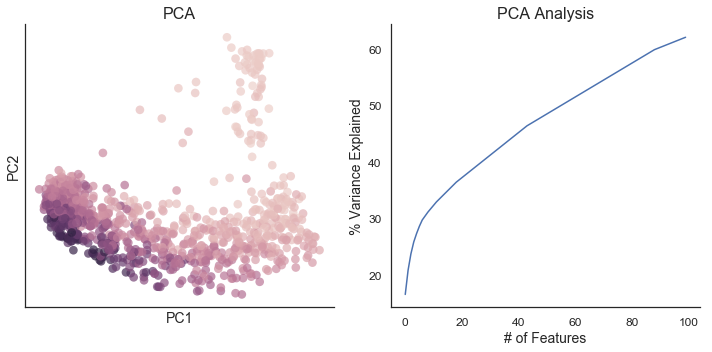

In [18]:
# look at the results
retina7_PCA.plot_PCA()
# plots are colored by point density in 2D space

Now we can perform our favorite low-dimensional embedding on the arcsinh-transformed data...

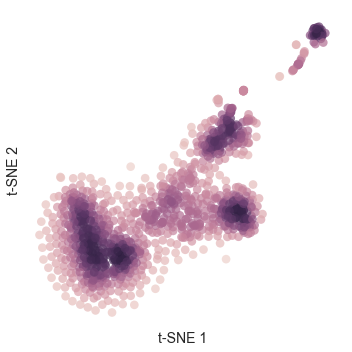

CPU times: user 7.05 s, sys: 131 ms, total: 7.18 s
Wall time: 7.1 s


In [20]:
%%time 
retina7_tSNE = fcc_tSNE(retina7_var_downsample.arcsinh_norm(norm='l1', scale=1000), perplexity=30)
retina7_tSNE.plot()

Or on the output of the PCA we performed:

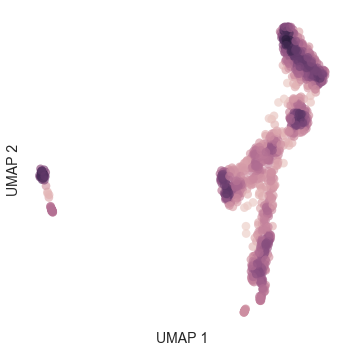

CPU times: user 7.31 s, sys: 314 ms, total: 7.62 s
Wall time: 7.66 s


In [22]:
%%time 
retina7_PCA_UMAP = fcc_UMAP(retina7_PCA.results, perplexity=30)
retina7_PCA_UMAP.plot()

Each of these dimensionality reduction (`DR`) objects we've created as a `.distance_matrix()` method so we can correlate the Euclidean distances across latent spaces pretty easily.

In [23]:
from fcc_utils import *
%time tSNE_dist, UMAP_dist, mantel_stats, EMD, KLD = distance_stats(pre=retina7_tSNE.distance_matrix(), post=retina7_PCA_UMAP.distance_matrix())

CPU times: user 15.6 s, sys: 2.27 s, total: 17.9 s
Wall time: 18.7 s


R: 0.878
n: 1000


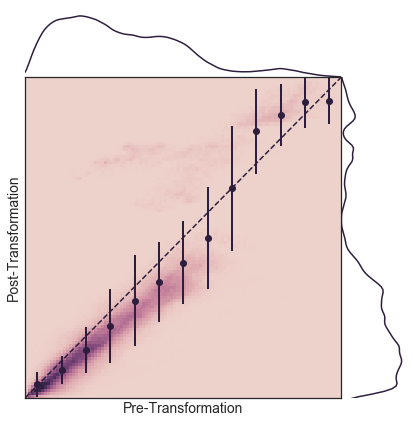

In [26]:
joint_plot_distance_correlation(tSNE_dist, UMAP_dist)
print('R: {}\nn: {}'.format(round(mantel_stats[0],4), mantel_stats[2]))

You can also look at the z-score normalized cumulative distance distributions in each projection and calculate Earth Mover's Distance and K-L Divergence between the two.

EMD: 0.0639
KLD: 0.0629


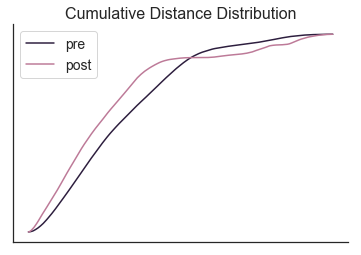

In [27]:
plot_cumulative_distributions(tSNE_dist, UMAP_dist)
print('EMD: {}\nKLD: {}'.format(round(EMD,4), round(KLD,4)))

Density peak clustering is built into the `DR` objects.  
We can look at the decision graph and assign cluster centers:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128bb45c0>)

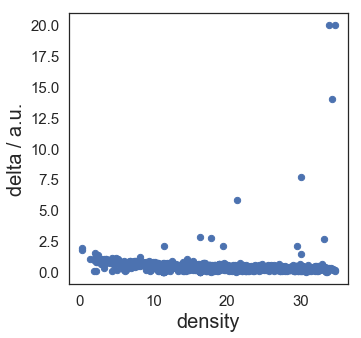

In [28]:
retina7_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129cb8a58>)

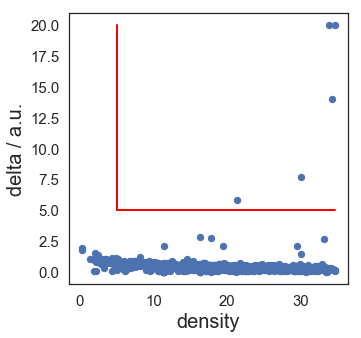

In [30]:
# now, if we assign cutoffs for density and delta, we can generate cluster membership for our tSNE
retina7_tSNE.clu.assign(5,5)
retina7_tSNE.clu.draw_decision_graph(min_delta=retina7_tSNE.clu.min_delta, min_density=retina7_tSNE.clu.min_density)

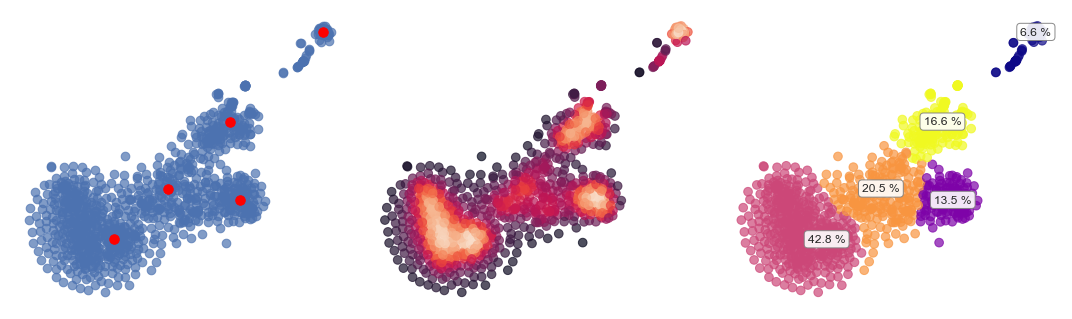

In [31]:
# finally, we can look at the clusters in our tSNE
retina7_tSNE.plot_clusters()

In [35]:
# silhouette score is automatically calculated as well
print('Silhouette Score: {}'.format(round(retina7_tSNE.silhouette_score(),3)))

Silhouette Score: 0.515999972820282


In [36]:
retina7_tSNE.cluster_counts()

66 cells in cluster 0 (6.6 %)

135 cells in cluster 1 (13.5 %)

428 cells in cluster 2 (42.8 %)

205 cells in cluster 3 (20.5 %)

166 cells in cluster 4 (16.6 %)



We can then use the `clu.membership` attribute to project clusters from one space to another embedding.

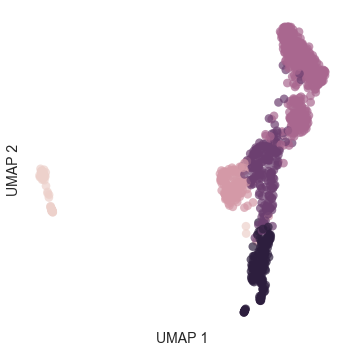

In [38]:
retina7_PCA_UMAP.plot(color=retina7_tSNE.clu.membership) # UMAP with t-SNE clusters